MyNetwork(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
model layer 1 weights
(10, 1, 5, 5)
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3085, 0.0000, 0.0000],
          [0.0000, 0.2718, 0.0000, 0.2624],
          [0.9515, 2.2666, 0.0000, 2.7650]],

         [[3.6229, 4.5624, 0.0000, 0.0000],
          [5.5759, 2.7212, 0.0000, 0.8843],
          [0.0000, 0.0000, 0.0000, 1.7741],
          [0.6335, 0.0000, 0.3563, 0.1127]],

         [[3.4574, 0.0000, 0.0000, 1.0633],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 4.6288],
          [0.0000, 0.0930, 0.0000, 4.7738]],

         ...,

         [[2.6311, 3.1525, 0.7414, 0.0000],
          [1.1851, 3.1709, 7.1451, 5.1387],
          [1.8746, 1.594

/tmp/ipykernel_102861/788381496.py:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axaar = plt.subplots(1,2)


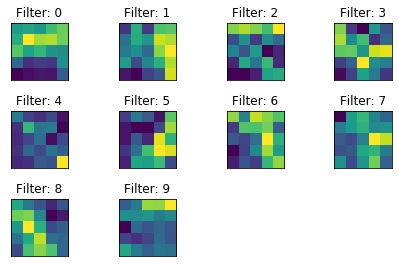

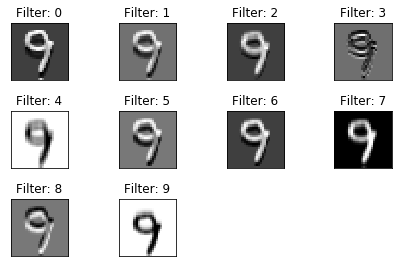

<Figure size 432x288 with 0 Axes>

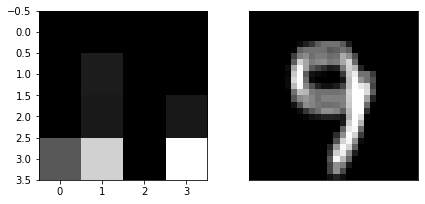

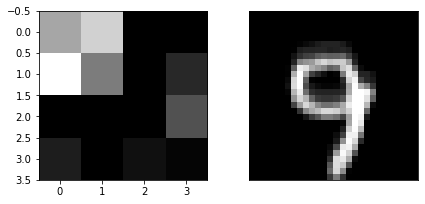

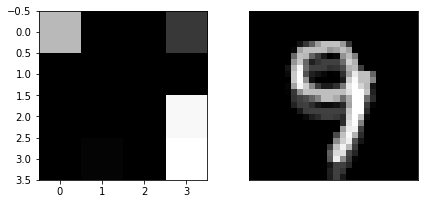

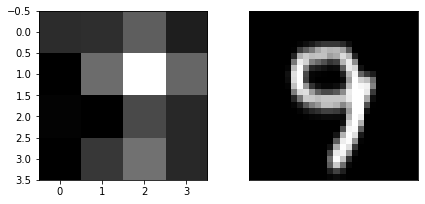

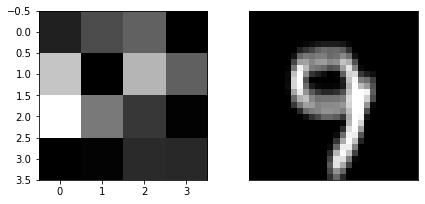

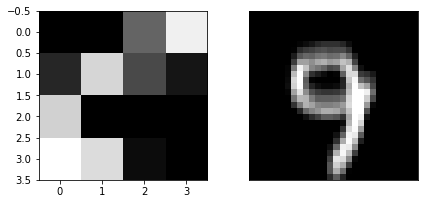

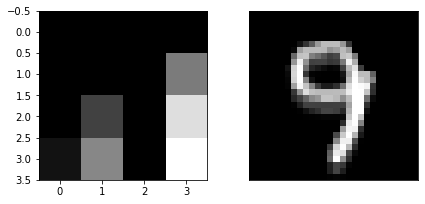

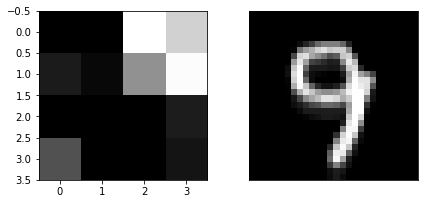

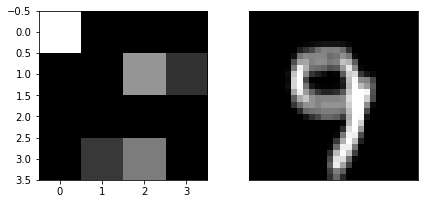

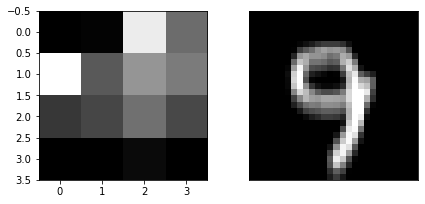

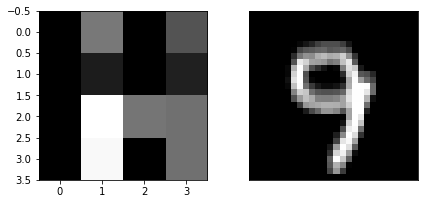

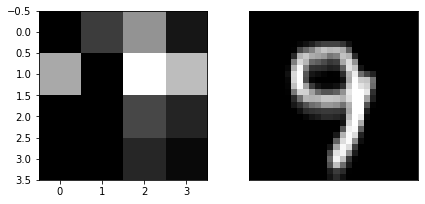

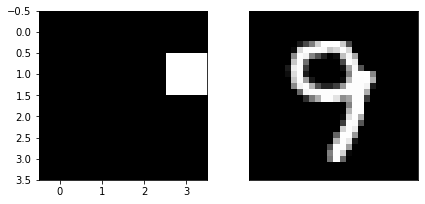

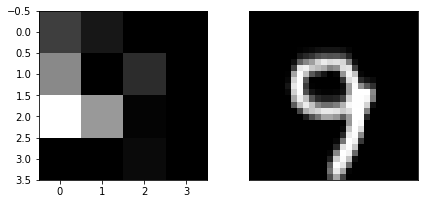

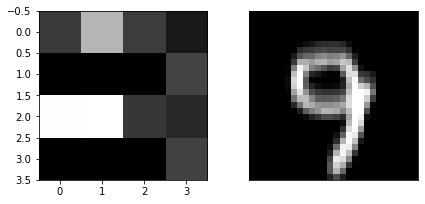

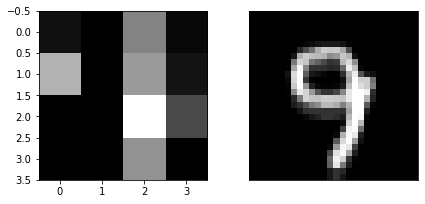

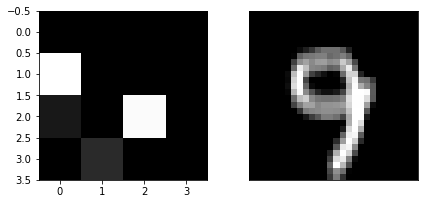

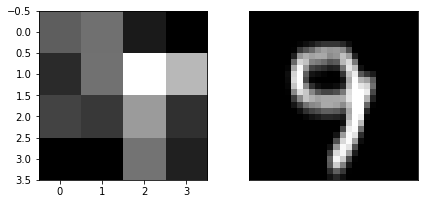

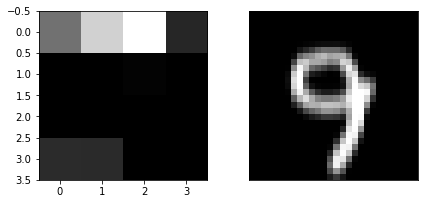

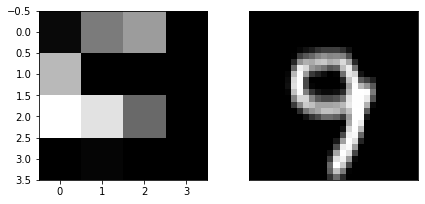

In [1]:
"""
Sequence Number : 3
Ravina Lad
Date : 11th March 2022
CS 5330 Computer Vision
Spring 2021

This Python file includes

- Task 2 : Examine your network
- Task A : Analyze the first layer
- Task B : Show the effect of the filters
- Task C : Build a truncated model
"""
import sys
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

#Netwrok Defination
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

class Submodel(MyNetwork):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    # override the forward method
    def forward( self, x ):
        x = F.relu( F.max_pool2d( self.conv1(x), 2 ) ) # relu on max pooled results of conv1
        x = F.relu( F.max_pool2d( self.conv2_drop( self.conv2(x)), 2 ) ) # relu on max pooled results of dropout of conv2
        return x

# main function to run process of loading MNIST data set
def main(argv):

    #declaration of all Hyperparameters used
    n_epochs = 5
    batch_size_train = 64
    batch_size_test = 1000
    learning_rate = 0.01
    momentum = 0.5
    log_interval = 10

    #Data loader 
    train_loader = torch.utils.data.DataLoader(
                  torchvision.datasets.MNIST('mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                      torchvision.transforms.Normalize(
                                                                      (0.1307,), (0.3081,)) ])),
    batch_size=batch_size_train, shuffle=True)
    

    #repeatable newtwork
    random_seed = 42
    torch.backends.cudnn.enabled = False
    torch.manual_seed(random_seed)

    #Test the network on new inputs (Handwritten Digits)
    continued_network = MyNetwork()
    continued_optimizer = optim.SGD(continued_network.parameters(), lr=learning_rate,
                                    momentum=momentum)
    
    # load the internal state of the network and optimizer when we last saved them.
    network_state_dict = torch.load('/home/ravina/Desktop/OpenCV/MNIST/modelFiles/model.pth')
    continued_network.load_state_dict(network_state_dict)

    optimizer_state_dict = torch.load('/home/ravina/Desktop/OpenCV/MNIST/modelFiles/optimizer.pth')
    continued_optimizer.load_state_dict(optimizer_state_dict)

    continued_network.eval()
    print(continued_network)

    print("model layer 1 weights")
    tensor_conv1 = continued_network.conv1.weight.detach().numpy()
   
    print(tensor_conv1.shape)
    fig = plt.figure()
    for i in range(10):
      plt.subplot(3,4,i+1)
      plt.tight_layout()
      plt.imshow(tensor_conv1[i, 0], interpolation='none')
      plt.title("Filter: {}".format(i))
      plt.xticks([])
      plt.yticks([])
    fig

    examples = enumerate(train_loader)
    batch_idx, (train_example, example_targets) = next(examples)

    #train_example1 = train_example.numpy().astype(np.float32)
    train_example1 = train_example.detach().numpy()
    
    
    with torch.no_grad():
      fig = plt.figure()
      for i in range(10):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        data = cv2.filter2D(train_example1[0], -1, tensor_conv1[i, 0])
        plt.imshow(data[0], cmap='gray', interpolation='none')
        plt.title("Filter: {}".format(i))
        plt.xticks([])
        plt.yticks([])
      fig

    submodel_object = Submodel()
    submodel_network_state_dict = torch.load('/home/ravina/Desktop/OpenCV/MNIST/modelFiles/model.pth')
    submodel_object.load_state_dict(submodel_network_state_dict)
    submodel_object.eval()

    with torch.no_grad():
      output = submodel_object(train_example)

    print(output)
    #Prediction of digits from examples data
    fig = plt.figure()
    for i in range(20):
      f, axaar = plt.subplots(1,2)
      plt.tight_layout()
      new_data = cv2.filter2D(train_example1[0], -1, output.data[0][i].detach().numpy())
      axaar[0].imshow(output.data[0, i], cmap='gray', interpolation='none')
      axaar[1].imshow(new_data[0], cmap='gray', interpolation='none')
      plt.xticks([])
      plt.yticks([])
    fig

    # for param in continued_network.parameters():
    #   print(param)
    return

if __name__ == "__main__":
    main(sys.argv)
